- https://huggingface.co/blog/deep-rl-ppo
    - TRPO: https://jonathan-hui.medium.com/rl-trust-region-policy-optimization-trpo-explained-a6ee04eeeee9
    - PPO: https://jonathan-hui.medium.com/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12

强化学习 (online) 和传统监督学习(offline)一个很大的区别就是“训练数据是当场采集出来的”，一边造数据，一边训模型，然后用新的模型接着造数据，训模型。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

$$
PPO_{clip}=\min(r(\theta)A, \text{clip}(r(\theta), 1-\epsilon, 1+\epsilon)A)
$$

- 策略更新比率（ratio）：$r(\theta)=\frac{\pi_\theta(a|s)}{\pi_{\theta_\text{old}}(a|s)}$
- Advantage（优势函数）本身不直接参与梯度计算
- PPO 的 clip 操作，会导致这条数据没有梯度，这条训练数据就起不到贡献了
    - $A\gt 0$（$r(\theta) > (1+\epsilon)$），截断为 $A(1+\epsilon)$，gradient 为 0
        - $r(\theta) < 1-\epsilon$，取值为 $Ar$，未被截断，gradient 为 A；
    - $A\lt 0$（$r(\theta) < (1-\epsilon)$），截断为 $A(1-\epsilon)$，gradient 为 0

### clip

- $A>0$ 时（鼓励 $\pi(a_t|s_t)$ 提升 likelihood ratio），$r\geq 1+\epsilon$，则取为 $(1+\epsilon)A$（梯度为0）
    - 目标函数此时没有梯度，不会继续增加 likelihood 
- $A<0$ 时（抑制 $\pi(a_t|s_t)$ 降低 likelihood ratio），$r \leq 1-\epsilon$，则取值为 $(1-\epsilon)A$（梯度为0）
- 还有一个问题，为什么不可以只取 $\text{clip}(r, 1-\epsilon, 1+\epsilon)A$
    - $A\gt 0$, $r \lt (1-\epsilon)$ 时（初始就已经偏离很大），有 $Ar \lt A(1-\epsilon)$，min 操作使得目标函数为 $Ar$ 继续保持梯度，提升 $r$（往上升）
    - $A\lt 0$, $r \gt (1+\epsilon)$ 时（初始就已经偏离很大），有 $Ar \lt A(1+\epsilon)$, min 操作使得目标函数为 $Ar$ 继续保持梯度，降低 $r$（往下拉）

In [2]:
def ppo_clip(r, A, eps=0.2):
    return np.minimum(r * A, np.clip(r, 1-eps, 1+eps) * A)

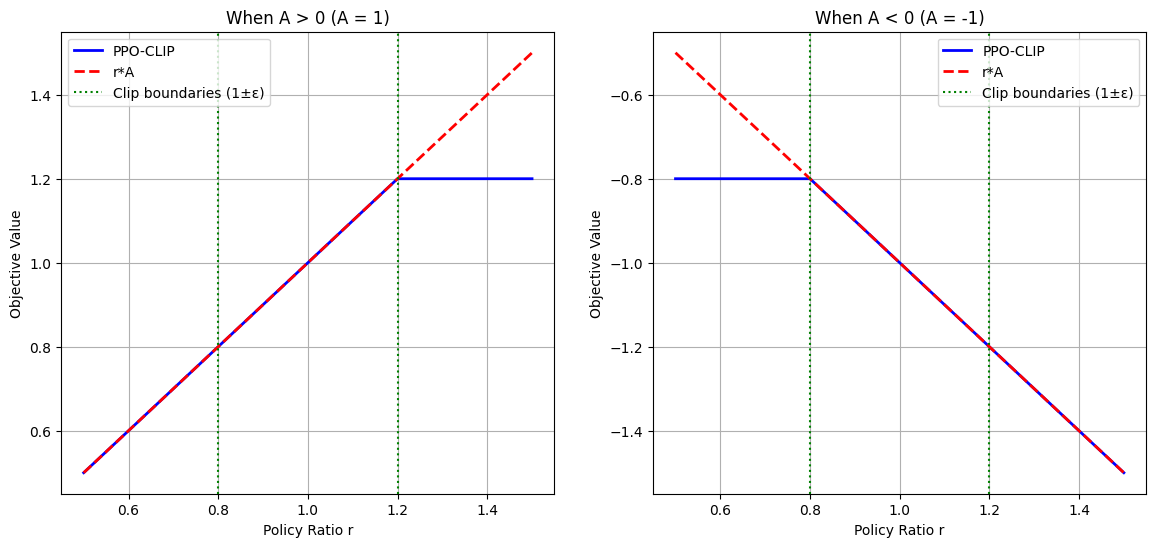

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Set basic parameters
eps = 0.2
r_values = np.linspace(0.5, 1.5, 1000)  # r uniformly distributed from 0.5 to 1.5

# First case: A > 0 (A = 1)
A = 1
ppo_values = ppo_clip(r_values, A, eps)
original_values = r_values * A  # Original policy gradient objective

axs[0].plot(r_values, ppo_values, 'b-', linewidth=2, label='PPO-CLIP')
axs[0].plot(r_values, original_values, 'r--', linewidth=2, label='r*A')

# Draw clipping boundaries
axs[0].axvline(x=1-eps, color='g', linestyle=':', label='Clip boundaries (1±ε)')
axs[0].axvline(x=1+eps, color='g', linestyle=':')

axs[0].set_title('When A > 0 (A = 1)')
axs[0].set_xlabel('Policy Ratio r')
axs[0].set_ylabel('Objective Value')
axs[0].legend()
axs[0].grid(True)

# Second case: A < 0 (A = -1)
A = -1
ppo_values = ppo_clip(r_values, A, eps)
original_values = r_values * A  # Original policy gradient objective

axs[1].plot(r_values, ppo_values, 'b-', linewidth=2, label='PPO-CLIP')
axs[1].plot(r_values, original_values, 'r--', linewidth=2, label='r*A')

# Draw clipping boundaries
axs[1].axvline(x=1-eps, color='g', linestyle=':', label='Clip boundaries (1±ε)')
axs[1].axvline(x=1+eps, color='g', linestyle=':')

axs[1].set_title('When A < 0 (A = -1)')
axs[1].set_xlabel('Policy Ratio r')
axs[1].set_ylabel('Objective Value')
axs[1].legend()
axs[1].grid(True)

- we take the minimum of the clipped and unclipped objective, so the final objective is a **lower bound (i.e., a pessimistic bound)** on the unclipped objective.
    - https://arxiv.org/pdf/1707.06347

### unclipped part & clipped part

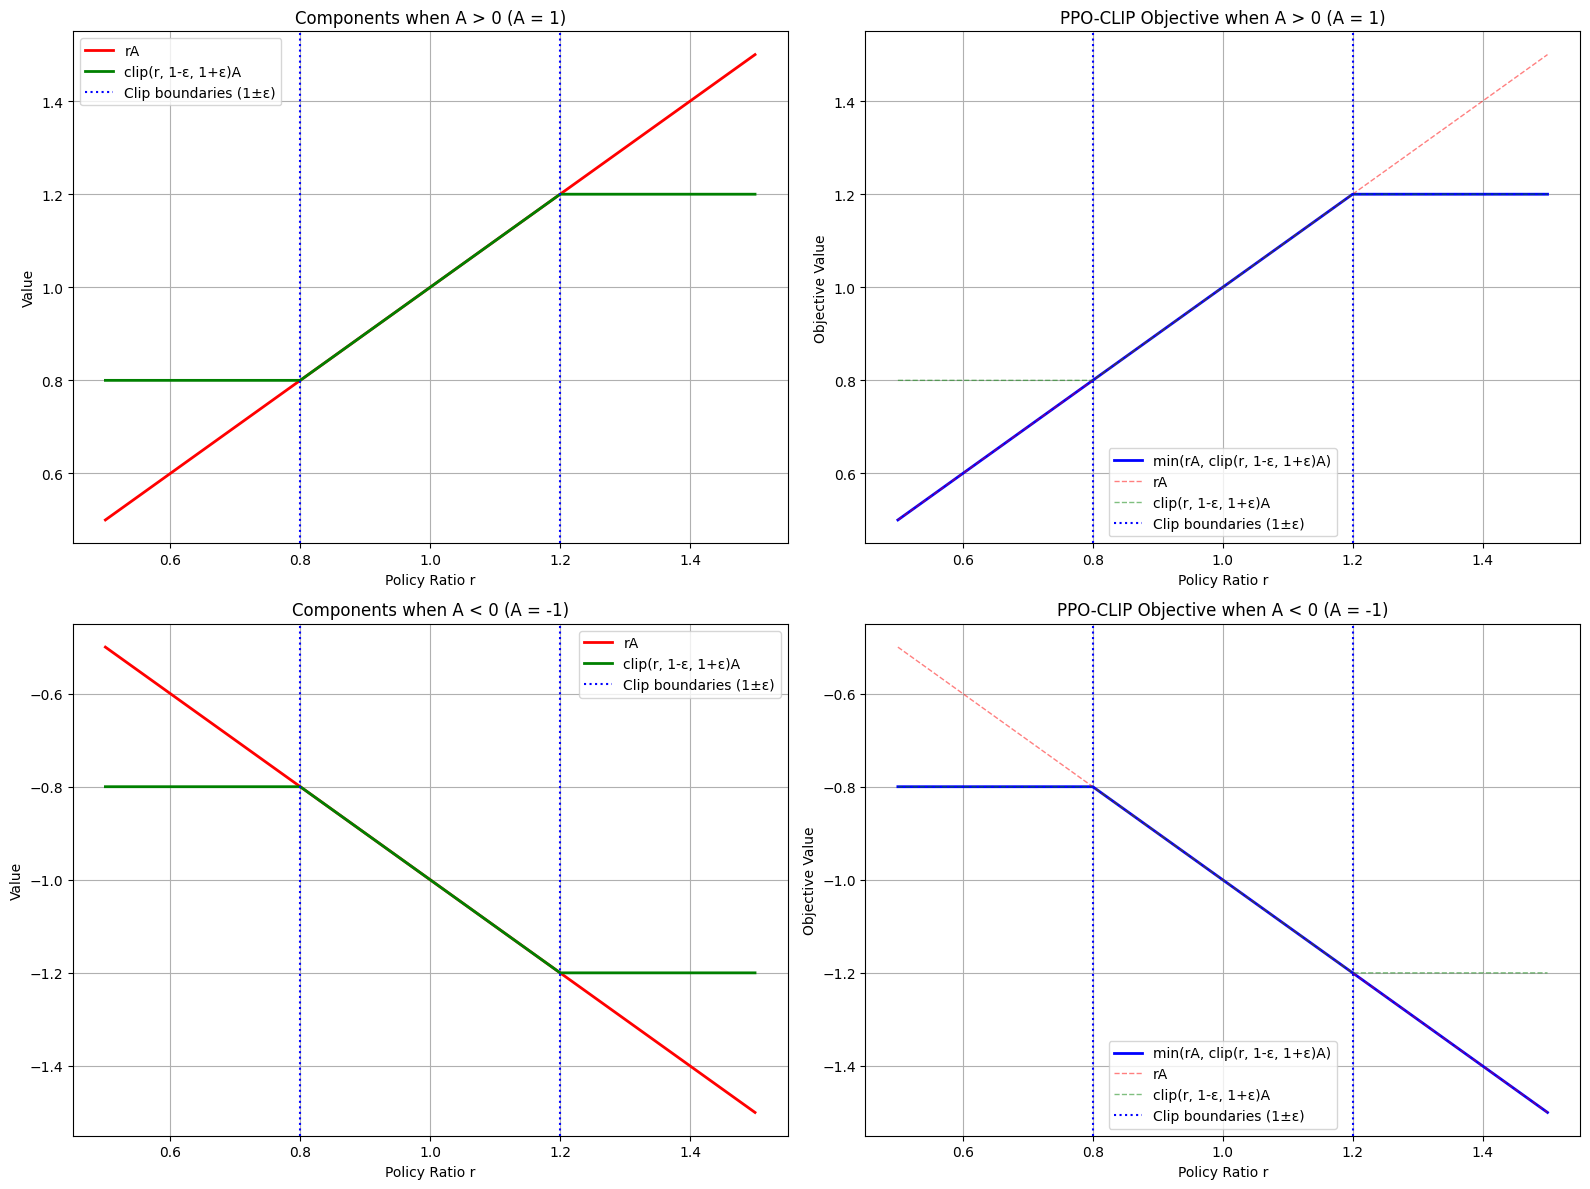

In [4]:
# Create 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Set basic parameters
eps = 0.2
r_values = np.linspace(0.5, 1.5, 1000)  # r uniformly distributed from 0.5 to 1.5

# Row 1: A > 0 (A = 1)
A = 1
original_values = r_values * A  # Original policy gradient objective (rA)
clipped_values = np.clip(r_values, 1-eps, 1+eps) * A  # Clipped objective
ppo_values = ppo_clip(r_values, A, eps)  # PPO-CLIP objective

# Row 1, Col 1: rA and clip(r, 1-eps, 1+eps)A separately for A > 0
axs[0, 0].plot(r_values, original_values, 'r-', linewidth=2, label='rA')
axs[0, 0].plot(r_values, clipped_values, 'g-', linewidth=2, label='clip(r, 1-ε, 1+ε)A')
axs[0, 0].axvline(x=1-eps, color='b', linestyle=':', label='Clip boundaries (1±ε)')
axs[0, 0].axvline(x=1+eps, color='b', linestyle=':')
axs[0, 0].set_title('Components when A > 0 (A = 1)')
axs[0, 0].set_xlabel('Policy Ratio r')
axs[0, 0].set_ylabel('Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Row 1, Col 2: min(rA, clip(r, 1-eps, 1+eps)A) for A > 0
axs[0, 1].plot(r_values, ppo_values, 'b-', linewidth=2, label='min(rA, clip(r, 1-ε, 1+ε)A)')
axs[0, 1].plot(r_values, original_values, 'r--', linewidth=1, alpha=0.5, label='rA')
axs[0, 1].plot(r_values, clipped_values, 'g--', linewidth=1, alpha=0.5, label='clip(r, 1-ε, 1+ε)A')
axs[0, 1].axvline(x=1-eps, color='b', linestyle=':', label='Clip boundaries (1±ε)')
axs[0, 1].axvline(x=1+eps, color='b', linestyle=':')
axs[0, 1].set_title('PPO-CLIP Objective when A > 0 (A = 1)')
axs[0, 1].set_xlabel('Policy Ratio r')
axs[0, 1].set_ylabel('Objective Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Row 2: A < 0 (A = -1)
A = -1
original_values = r_values * A  # Original policy gradient objective (rA)
clipped_values = np.clip(r_values, 1-eps, 1+eps) * A  # Clipped objective
ppo_values = ppo_clip(r_values, A, eps)  # PPO-CLIP objective

# Row 2, Col 1: rA and clip(r, 1-eps, 1+eps)A separately for A < 0
axs[1, 0].plot(r_values, original_values, 'r-', linewidth=2, label='rA')
axs[1, 0].plot(r_values, clipped_values, 'g-', linewidth=2, label='clip(r, 1-ε, 1+ε)A')
axs[1, 0].axvline(x=1-eps, color='b', linestyle=':', label='Clip boundaries (1±ε)')
axs[1, 0].axvline(x=1+eps, color='b', linestyle=':')
axs[1, 0].set_title('Components when A < 0 (A = -1)')
axs[1, 0].set_xlabel('Policy Ratio r')
axs[1, 0].set_ylabel('Value')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Row 2, Col 2: min(rA, clip(r, 1-eps, 1+eps)A) for A < 0
axs[1, 1].plot(r_values, ppo_values, 'b-', linewidth=2, label='min(rA, clip(r, 1-ε, 1+ε)A)')
axs[1, 1].plot(r_values, original_values, 'r--', linewidth=1, alpha=0.5, label='rA')
axs[1, 1].plot(r_values, clipped_values, 'g--', linewidth=1, alpha=0.5, label='clip(r, 1-ε, 1+ε)A')
axs[1, 1].axvline(x=1-eps, color='b', linestyle=':', label='Clip boundaries (1±ε)')
axs[1, 1].axvline(x=1+eps, color='b', linestyle=':')
axs[1, 1].set_title('PPO-CLIP Objective when A < 0 (A = -1)')
axs[1, 1].set_xlabel('Policy Ratio r')
axs[1, 1].set_ylabel('Objective Value')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()